In [6]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

In [7]:
import matplotlib as mpl
import mplhep as hep
import mplhep.label as label_base
plt.style.use(hep.style.CMS)

In [8]:
inputlist = [
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5', 
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5' 
]

In [17]:
def get_mass_j1sdb_j2sdb(in_file):

    f_bb = pd.read_hdf(in_file)
    dt = f_bb.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])


    correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
    dt = dt[correct]
    correct = (dt[:,3]>100)
    dt = dt[correct]

    correct = (dt[:,19]>20)
    dt = dt[correct]

    correct = (dt[:,0]>=2800)
    dt = dt[correct]

    bsmlike = np.where(dt[:,16]>0.9)[0]
    dt = dt[bsmlike]
    
    addmask = np.where((dt[:,16]>0.90) )[0]
    #dt = dt[addmask]
    j1sdb = dt[:,3]*dt[:,16]
    j2sdb = dt[:,19]*dt[:,32]

    return dt[:,0], j1sdb, j2sdb, addmask

In [18]:
mjj, j1sdb1, j2sdb1, mask = get_mass_j1sdb_j2sdb(inputlist[1])
mjj_bkg , j1sdb1_bkg, j2sdb1_bkg, mask_bkg = get_mass_j1sdb_j2sdb(inputlist[3])

In [6]:
ae_def = {'type': 'bkg',
 'trainon': 'purebkg',
 'features': 'tauDDTwithm1andm1minusm2',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [7]:
bkgloss2_bb = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb2.npy")
bkgloss2_bkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")


ae_def = {'type': 'bkg',
 'trainon': 'rndbkg',
 'features': 'tauDDTwithm1andm1minusm2',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [4]:
ae_def = {'type': 'bkg',
 'trainon': 'purebkg',
 'features': 'NoDDT_withm1andm1minusm2',
 'architecture': 'MAF',
 'selection': 'mjj_mj1_mj2_cut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z4f10'}

In [5]:
bkgloss_bb = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb2.npy")
bkgloss_bkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")


In [10]:
ae_def = {'type': 'sig',
 'trainon': '2prong',
 'features': 'noddtnomass',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut0p9',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z4f10'}

In [11]:
prong2loss_bb = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb2.npy")
prong2loss_bkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")


In [127]:
ae_def = {'type': 'sig',
 'trainon': '3prong',
 'features': 'tauDDTwithoutrawmass',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut0p9',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [128]:
prong3loss_bb = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb2.npy")
prong3loss_bkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")


In [129]:
len(bkgloss_bb)

242090

In [130]:
len(prong2loss_bb)

242090

In [131]:
len(prong3loss_bb)

242090

In [12]:
bkgloss2_bb = bkgloss2_bb[mask]
bkgloss2_bkg = bkgloss2_bkg[mask_bkg]
bkgloss_bb = bkgloss_bb[mask]
bkgloss_bkg = bkgloss_bkg[mask_bkg]
prong2loss_bb = prong2loss_bb[mask]
prong2loss_bkg = prong2loss_bkg[mask_bkg]
prong3loss_bb = prong3loss_bb[mask]
prong3loss_bkg = prong3loss_bkg[mask_bkg]

NameError: name 'bkgloss2_bb' is not defined

In [ ]:
len(bkgloss_bb)

In [ ]:
len(mjj)

In [135]:
# BB 2  THAT WORKS
#bbidx = np.where( (bkgloss_bb > 1.6) & (prong2loss_bb<1.15)& (prong3loss_bb<1.15))[0]
#bkgidx = np.where( (bkgloss_bkg > 1.3) & (prong2loss_bkg<.8))[0]

In [136]:
# BB 2 selection
#bbidx = np.where( (bkgloss_bb > 1.5) & (prong2loss_bb<.9) & (prong3loss_bb<.9))[0]
#bkgidx = np.where( (bkgloss_bkg > 1.5) & (prong2loss_bkg<.9) & (prong3loss_bkg<.9))[0]

In [244]:
masswindow1 = np.where((mjj>3200) & (mjj<3800))[0]

masswindow2 = np.where((mjj>3400) & (mjj<3425))[0]

masswindow3 = np.where((mjj>4800) & (mjj<5100))[0]

masswindow4 = np.where((mjj>5300) & (mjj<5700))[0]

masswindow5 = np.where((mjj>5600) & (mjj<6600))[0]

In [245]:
print(len(masswindow1),len(masswindow2),len(masswindow3),len(masswindow4),len(masswindow5))

81357 3899 4320 2441 2488


In [246]:
def multidim_cumsum(a):
    #print(a[...,::-1].cumsum(-1))
    out = a[...,::-1].cumsum(-1)[...,::-1][::-1,...].cumsum(-2)[::-1,...]
    #print(out)
    #for i in range(2,a.ndim+1):
    #    np.cumsum(out, axis=-i, out=out)
    #    print(out)
    return out

In [298]:
def get_2d_hist(sigloss, bkgloss, masswindow,xbins,ybins):
    H_raw, xbins,ybins = np.histogram2d(bkgloss[masswindow],-sigloss[masswindow],bins=(xbins,ybins),density=False)
    #fig = plt.figure(figsize=(8, 8))
    #ax = fig.add_subplot(111, title='pcolormesh: actual edges',aspect='equal')

    H_integral = H_raw[...,::-1].cumsum(-1)[...,::-1][::-1,...].cumsum(-2)[::-1,...]

    #H_norm = H_integral / H_integral[0,0]
    #H_norm = H_integral/len(bkgloss[masswindow])

    #a = hep.hist2dplot(H_norm, xbins, ybins)
    H_norm = H_integral

    H_norm = H_norm.T
    X, Y = np.meshgrid(xbins, ybins)

    #print(X,Y)
    plt.pcolormesh(X, Y, H_norm,norm = mpl.colors.LogNorm())
    plt.yscale('symlog')

    return H_norm
    #print(H_norm)
    #plt.imshow(H_norm, norm = mpl.colors.LogNorm(), interpolation='nearest', origin='low',extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
    #print(xbins,ybins)
    
    
    
    
    

In [299]:
xbins = np.concatenate((np.arange(0,5,.2),np.array([5],dtype=np.float)))

In [300]:
xbins

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])

In [301]:
ybins = np.concatenate((np.array([-5,-3],dtype=np.float),np.arange(-2,0,.1)))

In [302]:
ybins

array([-5. , -3. , -2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2,
       -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1])

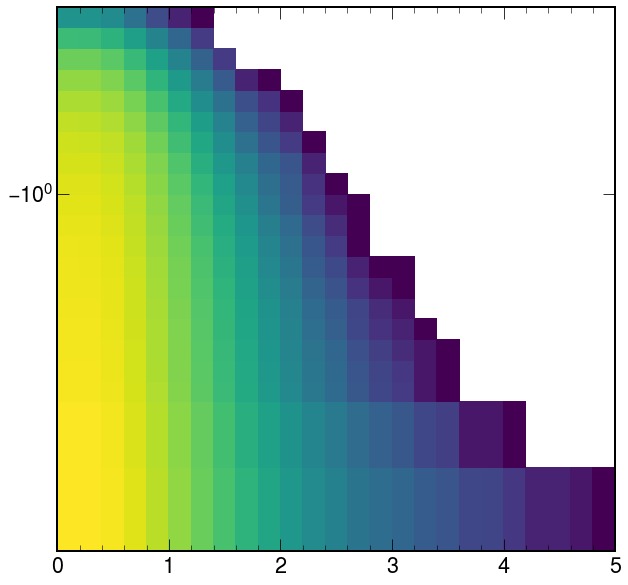

In [303]:
a = get_2d_hist(prong2loss_bb, bkgloss_bb, masswindow1, xbins,ybins)

array([[3.792e+03, 3.768e+03, 3.277e+03, 2.157e+03, 1.177e+03, 5.920e+02,
        2.940e+02, 1.310e+02, 6.400e+01, 3.600e+01, 1.900e+01, 9.000e+00,
        7.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.586e+03, 3.562e+03, 3.080e+03, 1.992e+03, 1.078e+03, 5.420e+02,
        2.660e+02, 1.120e+02, 5.500e+01, 3.200e+01, 1.700e+01, 8.000e+00,
        6.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.321e+03, 3.298e+03, 2.835e+03, 1.820e+03, 9.740e+02, 4.850e+02,
        2.340e+02, 1.020e+02, 4.900e+01, 2.700e+01, 1.300e+01, 5.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.276e+03, 3.253e+03, 2.794e+03, 1.795e+03, 

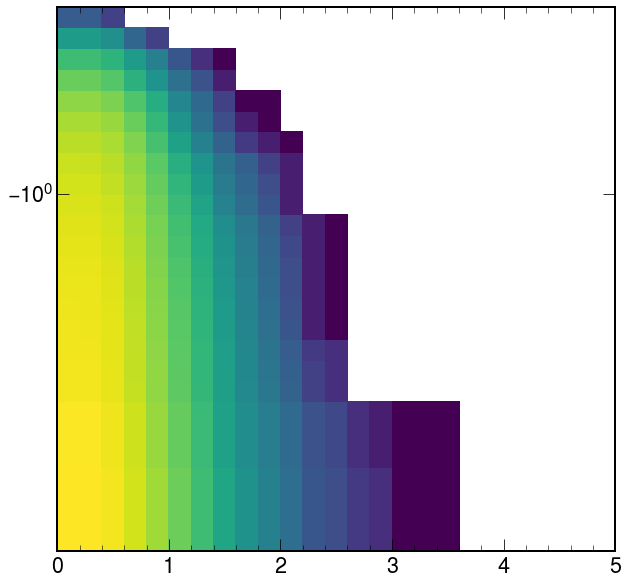

In [304]:
get_2d_hist(prong2loss_bb, bkgloss_bb, masswindow2, xbins,ybins)

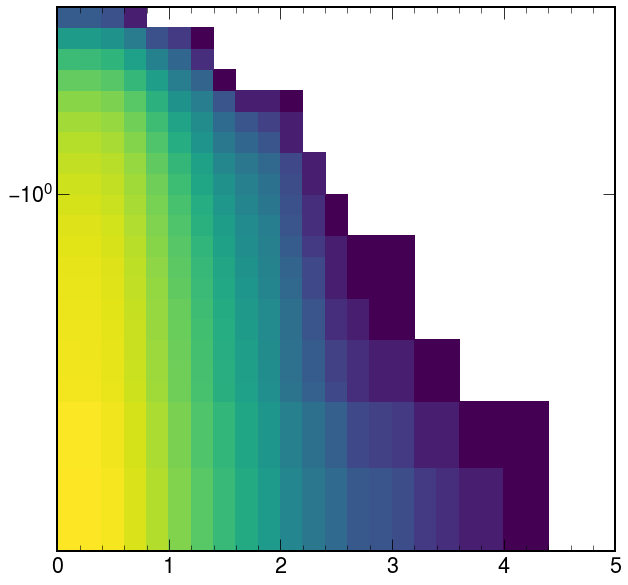

In [305]:
b = get_2d_hist(prong2loss_bb, bkgloss_bb, masswindow3, xbins,ybins)

In [306]:
d = np.where(b>a)

In [307]:
c = np.divide(b[:,:], np.sqrt(a[:,:]), out=np.zeros_like(b[:,:]), where=a[:,:]!=0)

In [308]:
ind = np.unravel_index(np.argmax(c, axis=None), c.shape)

In [309]:
ind

(0, 0)

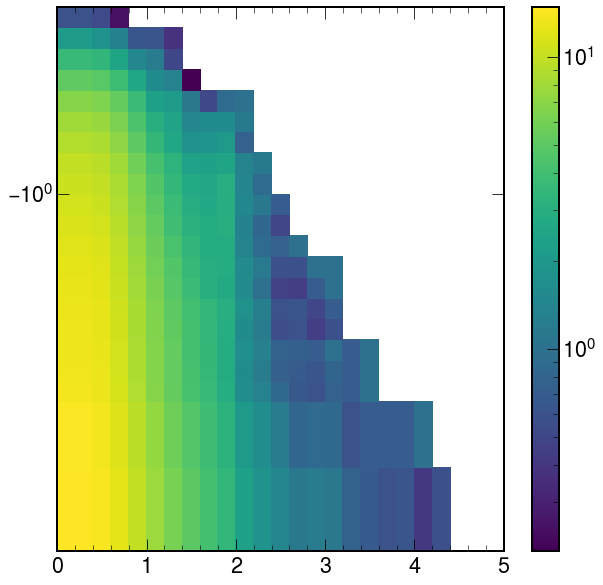

In [310]:
X, Y = np.meshgrid(xbins, ybins)

#print(X,Y)
plt.pcolormesh(X, Y,c,norm = mpl.colors.LogNorm())
plt.colorbar();
plt.yscale('symlog')

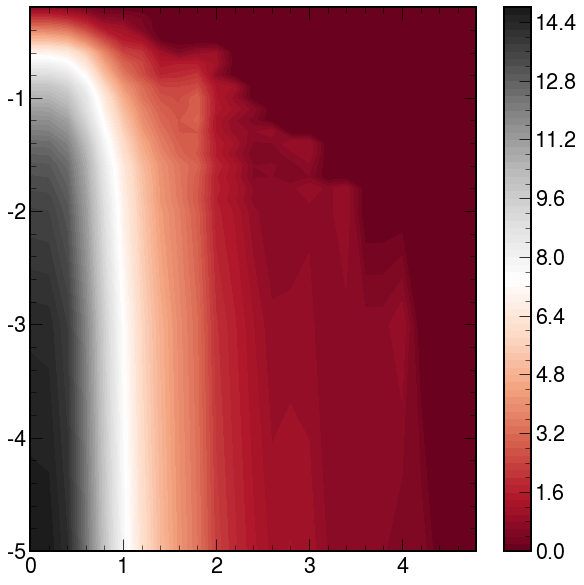

In [311]:
plt.contourf(X[:-1,:-1], Y[:-1,:-1], c, 80, cmap='RdGy')
plt.colorbar();

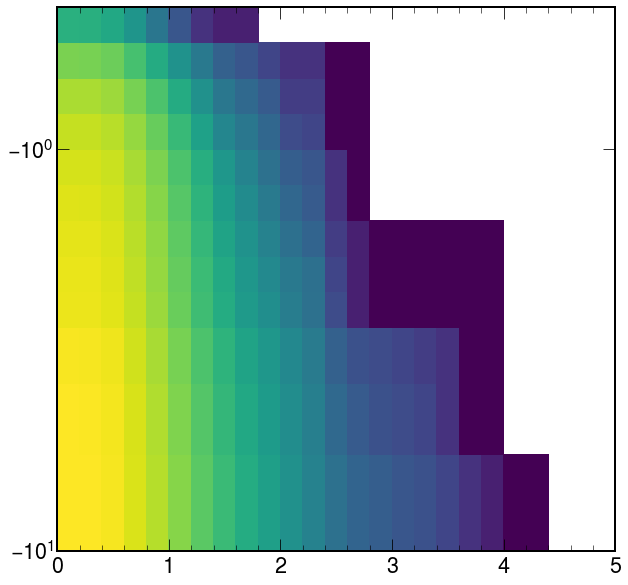

In [33]:
get_2d_hist(prong2loss_bb, bkgloss_bb, masswindow4, xbins,ybins)

(0.0, 10.0)

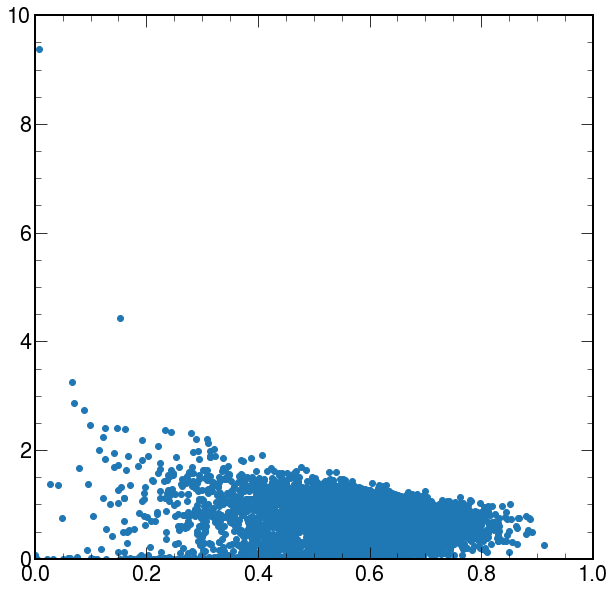

In [34]:
plt.scatter(np.exp(-bkgloss2_bb[masswindow1]),np.exp(bkgloss2_bb[masswindow1]-prong2loss_bb[masswindow1]));
plt.xlim([0,1])
plt.ylim([0,10])

(0.0, 10.0)

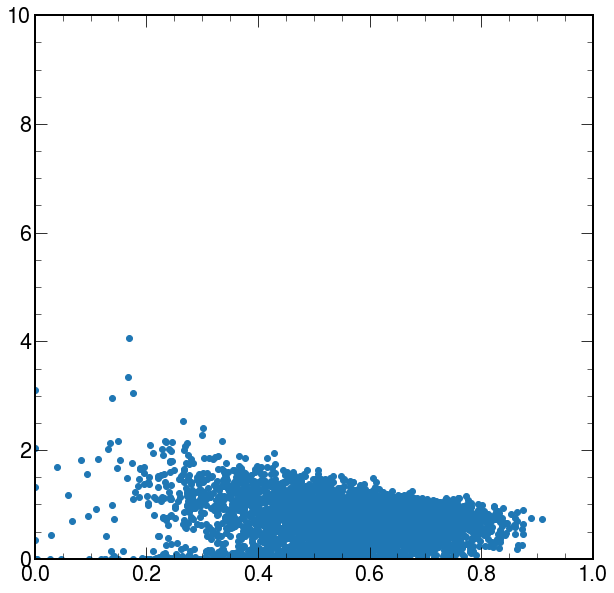

In [363]:
plt.scatter(np.exp(-bkgloss2_bb[masswindow2]),np.exp(bkgloss2_bb[masswindow2]-prong2loss_bb[masswindow2]));
plt.xlim([0,1])
plt.ylim([0,10])

(-0.1, 10.0)

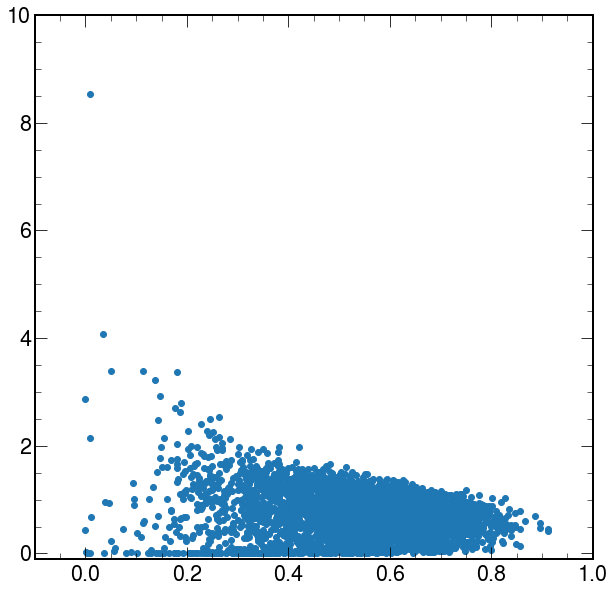

In [367]:
plt.scatter(np.exp(-bkgloss2_bb[masswindow3]),np.exp(bkgloss2_bb[masswindow3]-prong2loss_bb[masswindow3]));
plt.xlim([-0.1,1])
plt.ylim([-0.1,10])

(-0.1, 10.0)

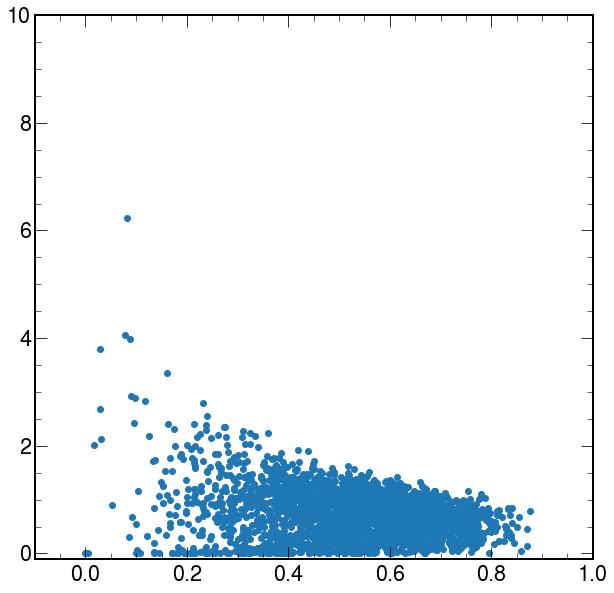

In [369]:
plt.scatter(np.exp(-bkgloss2_bb[masswindow4]),np.exp(bkgloss2_bb[masswindow4]-prong2loss_bb[masswindow4]));
plt.xlim([-0.1,1])
plt.ylim([-0.1,10])

(0.0, 10.0)

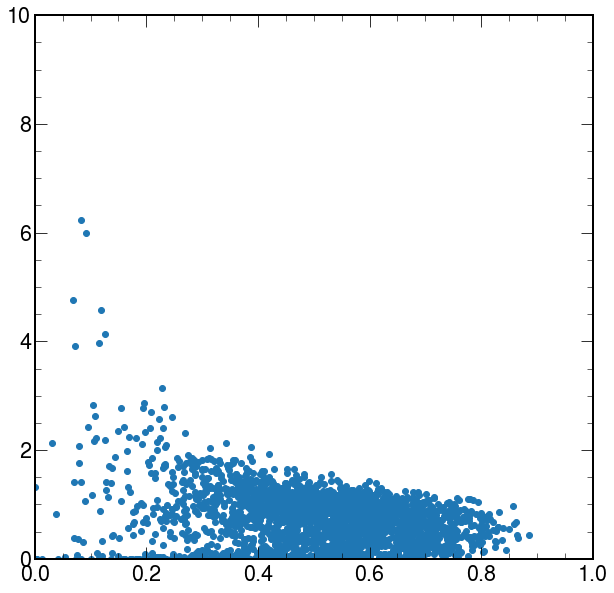

In [366]:
plt.scatter(np.exp(-bkgloss2_bb[masswindow5]),np.exp(bkgloss2_bb[masswindow5]-prong2loss_bb[masswindow5]));
plt.xlim([0,1])
plt.ylim([0,10])

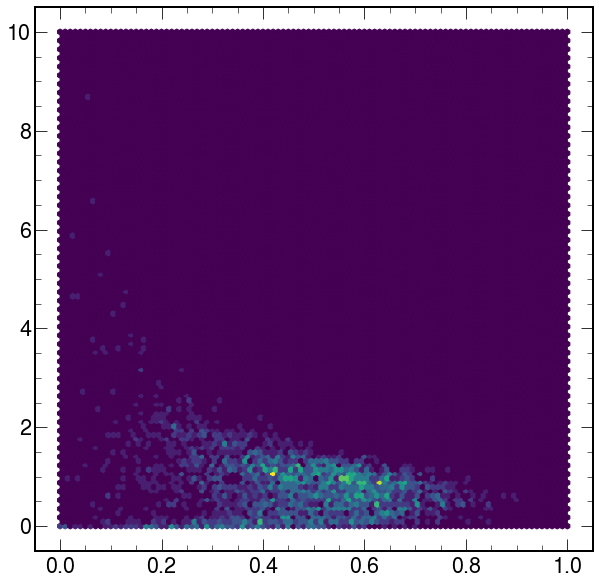

In [361]:
plt.hexbin(np.exp(-bkgloss_bb[masswindow5]),np.exp(bkgloss_bb[masswindow5]-prong2loss_bb[masswindow5]),extent=(0,1,0,10));


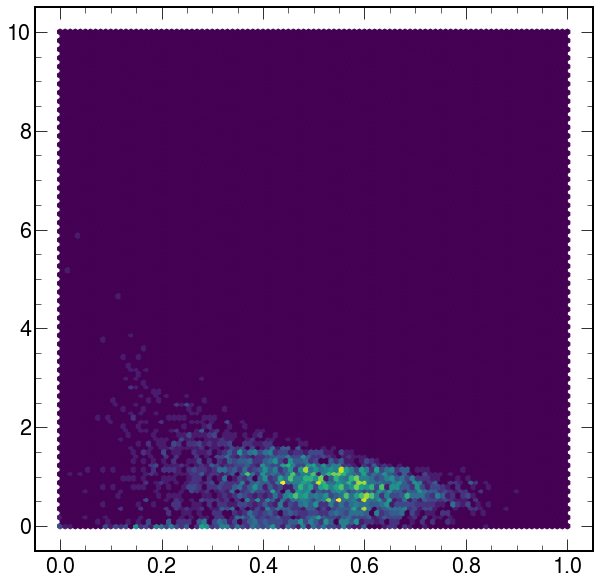

In [359]:
plt.hexbin(np.exp(-bkgloss_bb[masswindow3]),np.exp(bkgloss_bb[masswindow3]-prong2loss_bb[masswindow3]),extent=(0,1,0,10));


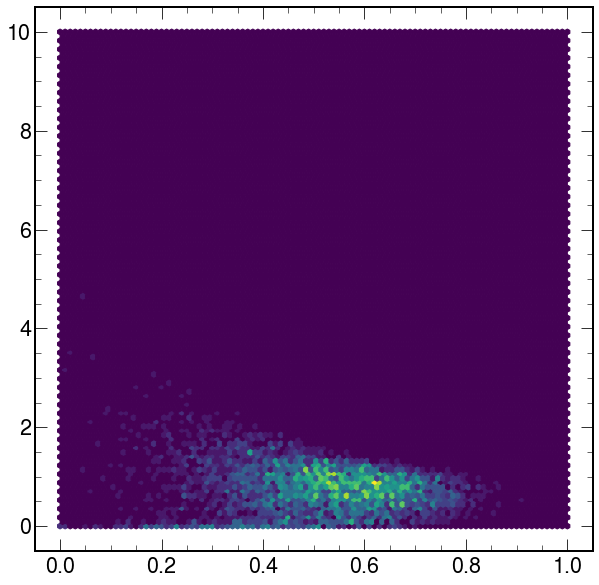

In [360]:
plt.hexbin(np.exp(-bkgloss_bb[masswindow1]),np.exp(bkgloss_bb[masswindow1]-prong2loss_bb[masswindow1]),extent=(0,1,0,10));


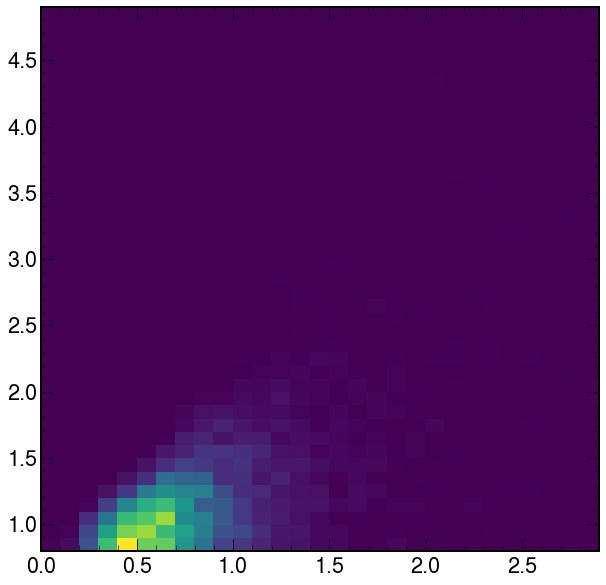

In [288]:
plt.hist2d(bkgloss_bb[masswindow],np.exp(bkgloss_bb[masswindow]-prong2loss_bb[masswindow]),bins=[np.arange(0,3,.1),np.arange(.8,5,.1)],density=True);

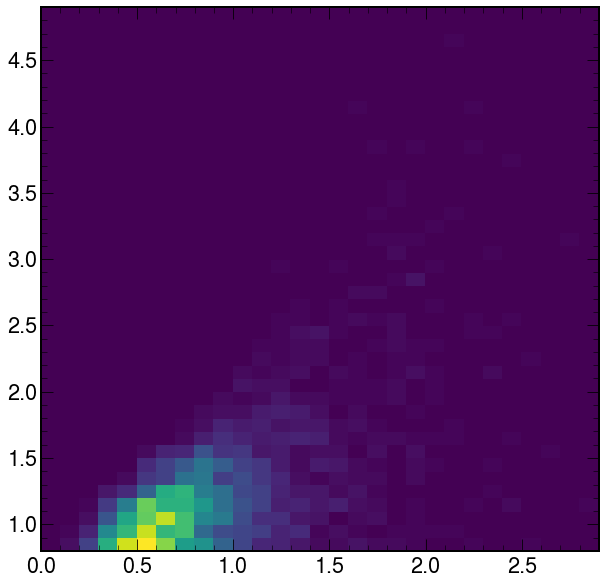

In [287]:
plt.hist2d(bkgloss_bb[masswindow3],np.exp(bkgloss_bb[masswindow3]-prong2loss_bb[masswindow3]),bins=[np.arange(0,3,.1),np.arange(.8,5,.1)],density=True);

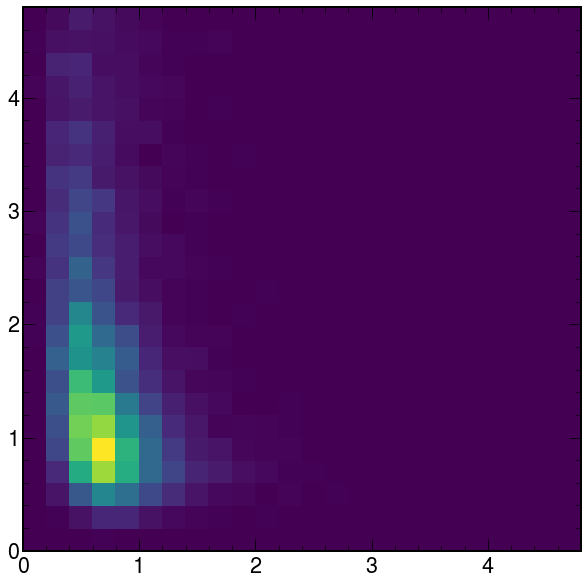

In [272]:
plt.hist2d(bkgloss_bb[masswindow],np.divide(prong2loss_bb[masswindow],bkgloss_bb[masswindow]),bins=[np.arange(0,5,.2),np.arange(0,5,.2)],density=True);

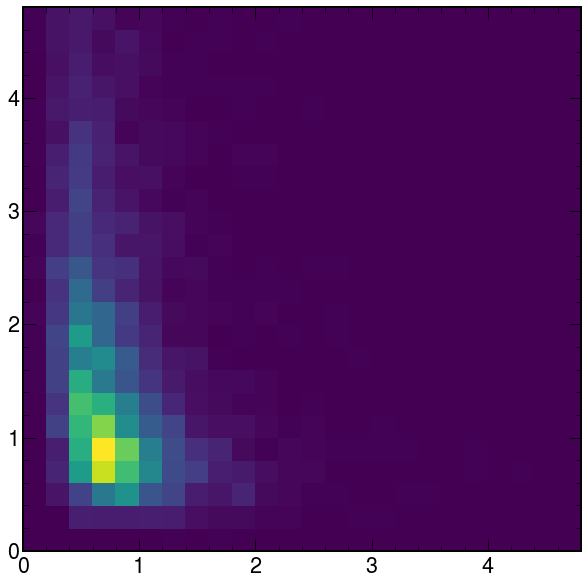

In [271]:
plt.hist2d(bkgloss_bb[masswindow3],np.divide(prong2loss_bb[masswindow3],bkgloss_bb[masswindow3]),bins=[np.arange(0,5,.2),np.arange(0,5,.2)],density=True);

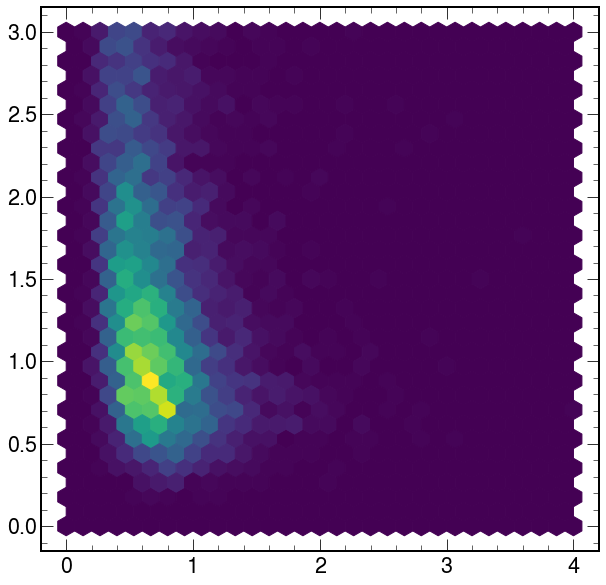

In [265]:
plt.hexbin(bkgloss_bb[masswindow],np.divide(prong2loss_bb[masswindow],bkgloss_bb[masswindow]),extent= (0, 4, 0, 3),gridsize=30);

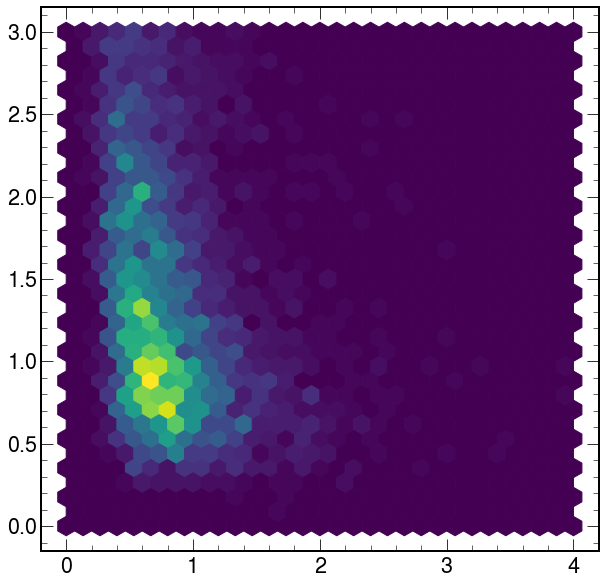

In [264]:
plt.hexbin(bkgloss_bb[masswindow3],np.divide(prong2loss_bb[masswindow3],bkgloss_bb[masswindow3]),extent= (0, 4, 0, 3),gridsize=30);

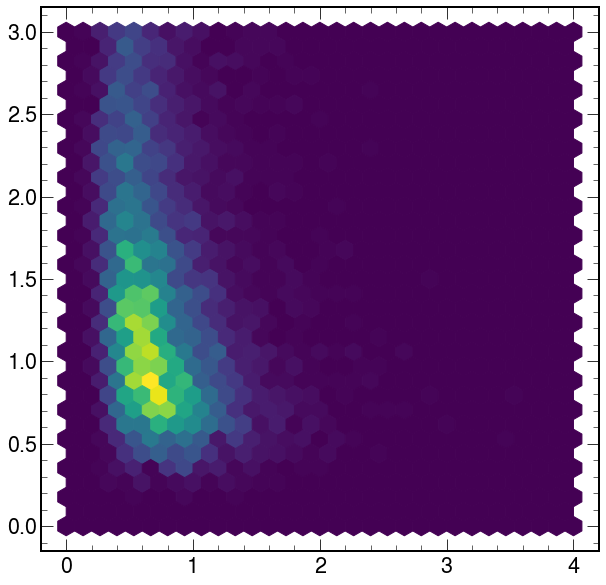

In [266]:
plt.hexbin(bkgloss_bb[masswindow2],np.divide(prong2loss_bb[masswindow2],bkgloss_bb[masswindow2]),extent= (0, 4, 0, 3),gridsize=30);

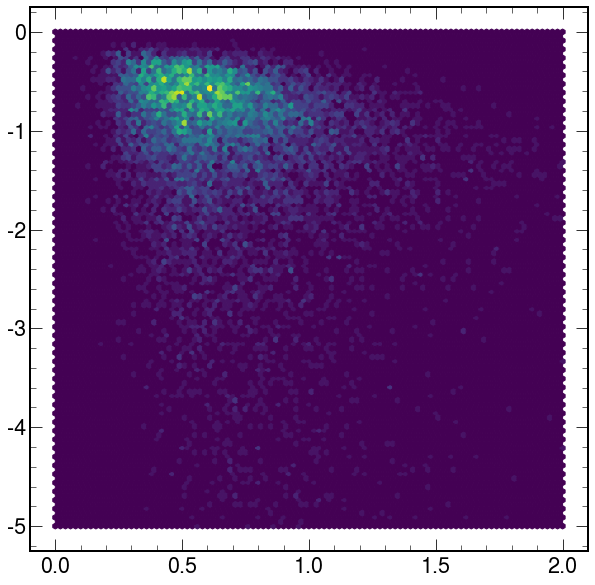

In [228]:
plt.hexbin(bkgloss_bb[masswindow],-prong2loss_bb[masswindow],extent= (0, 2, -5, 0));

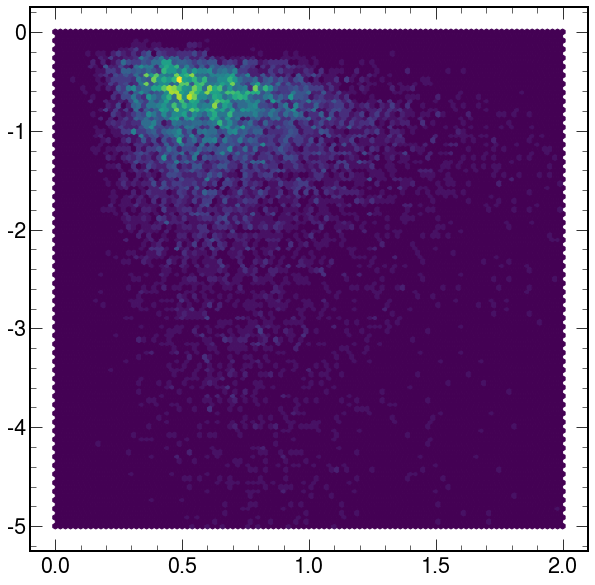

In [229]:
plt.hexbin(bkgloss_bb[masswindow2],-prong2loss_bb[masswindow2],extent= (0, 2, -5, 0));

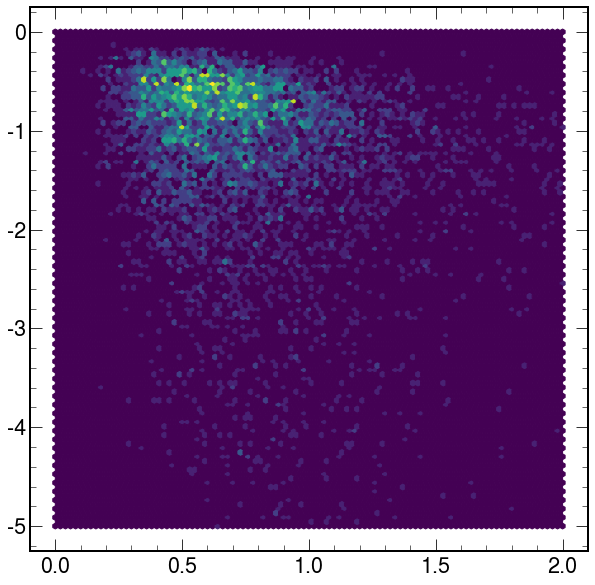

In [230]:
plt.hexbin(bkgloss_bb[masswindow3],-prong2loss_bb[masswindow3],extent= (0, 2, -5, 0));

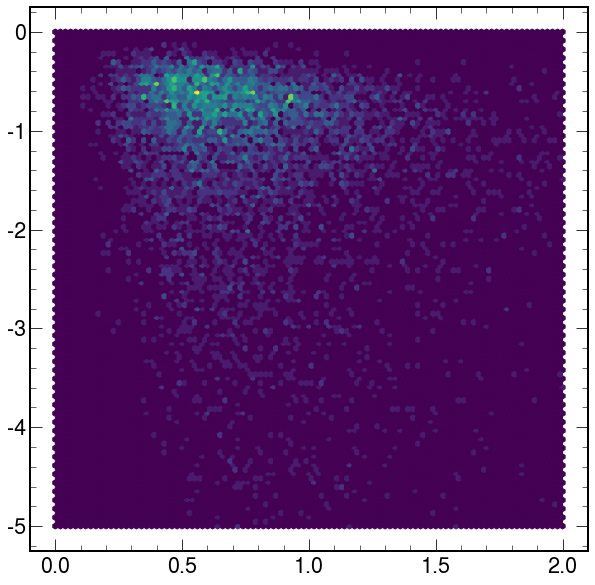

In [231]:
plt.hexbin(bkgloss_bb[masswindow4],-prong2loss_bb[masswindow4],extent= (0, 2, -5, 0));

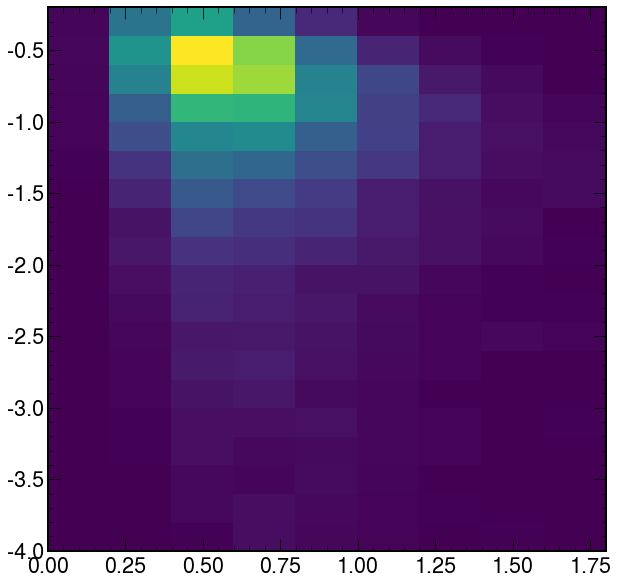

In [30]:
a = plt.hist2d(bkgloss_bb[masswindow],prong2loss_bb[masswindow],bins=[np.arange(0,2,.2),np.arange(-4,0,.2)],density=True);

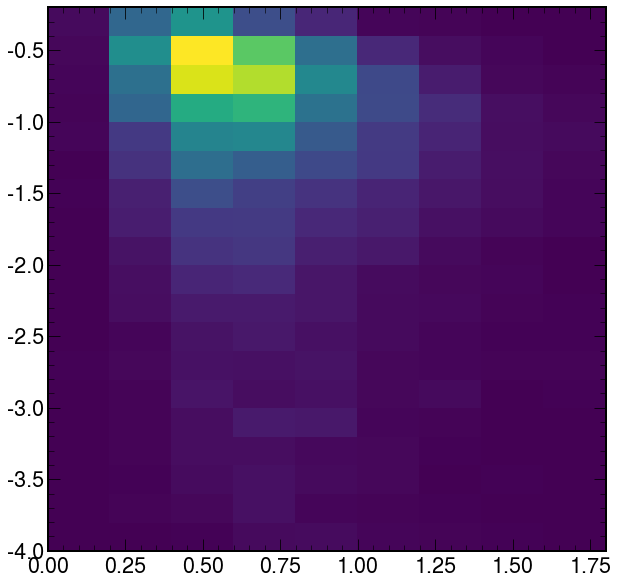

In [27]:
plt.hist2d(bkgloss_bb[masswindow2],-prong2loss_bb[masswindow2],bins=[np.arange(0,2,.2),np.arange(-4,0,.2)],density=True);

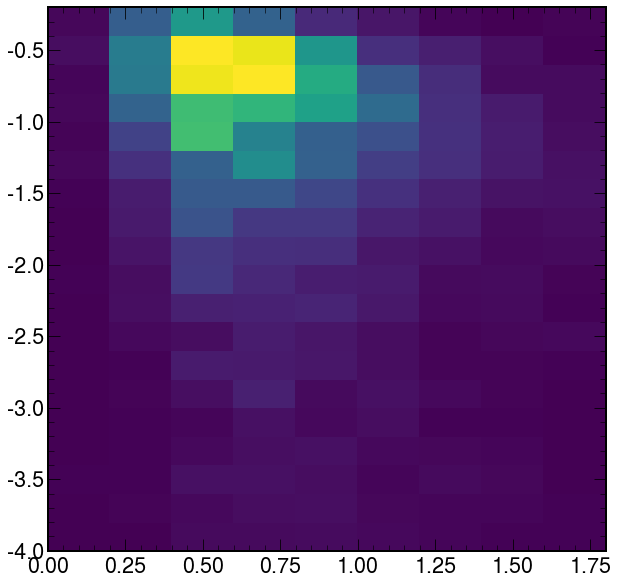

In [28]:
plt.hist2d(bkgloss_bb[masswindow3],-prong2loss_bb[masswindow3],bins=[np.arange(0,2,.2),np.arange(-4,0,.2)],density=True);

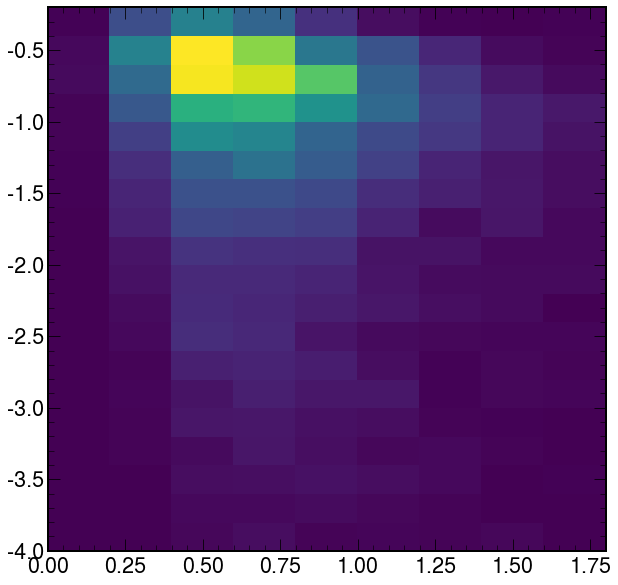

In [29]:
plt.hist2d(bkgloss_bb[masswindow4],-prong2loss_bb[masswindow4],bins=[np.arange(0,2,.2),np.arange(-4,0,.2)],density=True);

In [ ]:
plt.scatter(bkgloss_bb[masswindow],-prong2loss_bb[masswindow])
plt.scatter(bkgloss_bb[masswindow2],-prong2loss_bb[masswindow2])

plt.xlim([0,10])
plt.ylim([-25,0])

In [386]:
#BB2 Alternate Approaches
pbkg = np.exp(-bkgloss2_bb[masswindow3])
psigover = np.exp(bkgloss2_bb[masswindow3]-prong2loss_bb[masswindow3])

bbidx = np.where((psigover>1.))[0]

In [387]:
len(bbidx)

876

In [29]:
##BB2 temporary
bbidx = np.where( (bkgloss_bb > 1.5) & (prong2loss_bb<.8))[0]

In [30]:
print(len(bbidx))
#print(len(bkgidx))

829


In [31]:
BBTYPE = 'Black Box 2'
#priorusage = '2prongprior'
#priorusage = '2prongprior_withtrimmedmasscutbyeyeball'
#priorusage = '3prongprior'
#priorusage = '3prongprior_withtrimmedmasscutbyeyeball_j1200j2600'
#priorusage = 'allprior'
priorusage = 'TESTING'
BBTYPE_FILENAME = 'BB2'
savedir = 'analysis'

(3000.0, 7000.0)

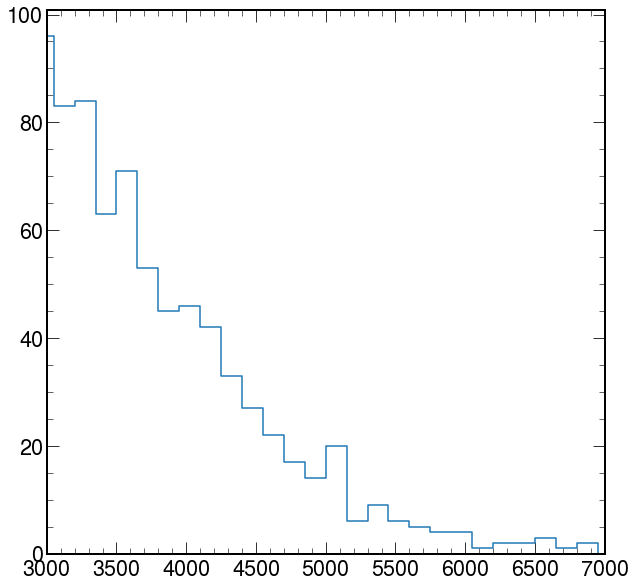

In [32]:
h, bins = np.histogram(mjj[bbidx],bins=np.arange(2900,7000,150))
#plt.axvline(x=3823)
hep.histplot(h, bins)
plt.xlim([3000,7000])

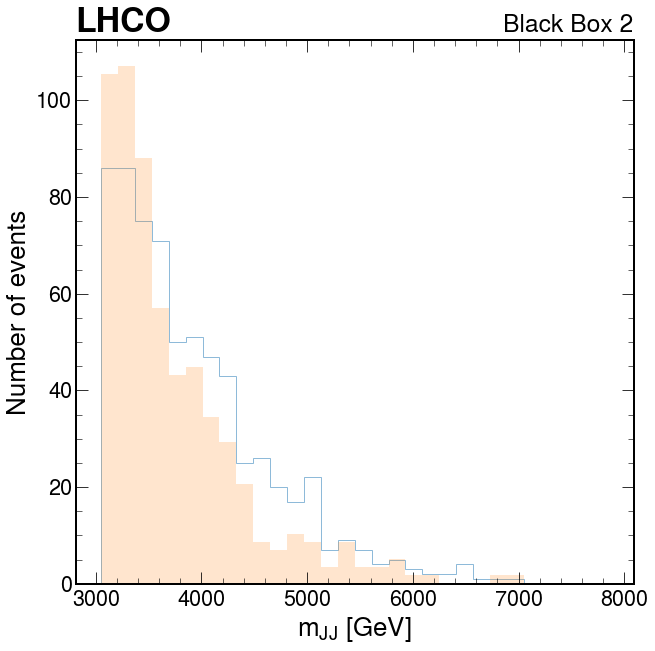

In [35]:
bins = np.arange(3050,8000,160)
obs_hist = plt.hist(mjj[bbidx],bins=bins,density=False,alpha=0.5,histtype='step')

sideband = mjj[bbidx][((j1sdb1[bbidx]<560)&(j1sdb1[bbidx]>100)) | ((j1sdb1[bbidx]<3000)&(j1sdb1[bbidx]>950))]

bkg_hist = plt.hist(sideband,bins=bins,weights=np.ones(len(sideband))*(len(mjj[bbidx])/len(sideband)) , density=False,alpha=0.2)

#plt.hist(mjj_bkg[bkgidx],bins=np.arange(2900,7000,200),density=True,alpha=0.5)
#sideband_left = plt.hist(mjj[bbidx][(j1sdb1[bbidx]<3600)&(j1sdb1[bbidx]>3400)])
#sideband_left = plt.hist(mjj[(bbidx)&(j1sdb1<4200)&(j1sdb1>4000)])
#plt.axvline(x=3823)
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
#plt.yscale('log')
#plt.title('subplot 1')
#hep.cms.cmslabel(data=False, paper=False, year='2017')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.legend(loc='upper right')
#np.save('')
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_MJJ.png')
#print(a)

In [212]:
bins

array([3050, 3200, 3350, 3500, 3650, 3800, 3950, 4100, 4250, 4400, 4550,
       4700, 4850, 5000, 5150, 5300, 5450, 5600, 5750, 5900, 6050, 6200,
       6350, 6500, 6650, 6800, 6950, 7100, 7250, 7400, 7550, 7700, 7850])

In [171]:
obs_hist[0]

array([839., 752., 662., 534., 447., 336., 330., 252., 214., 167., 142.,
       108.,  86.,  98.,  52.,  56.,  39.,  35.,  37.,  26.,  12.,  16.,
        16.,   9.,   9.,   7.,   4.,   1.,   0.,   2.,   3.,   1.])

In [213]:
import ROOT as r

xlow, xhigh = bins[0],bins[-1]
BINS = len(bins)-1


roothist_obs = r.TH1F('data_obs','data_obs',BINS,xlow,xhigh)
roothist_bkg = r.TH1F('bkgestimate','bkgestimate',BINS,xlow,xhigh)

for i in range(0,BINS):
    roothist_obs.SetBinContent(i+1,obs_hist[0][i])
    roothist_bkg.SetBinContent(i+1,bkg_hist[0][i])
    #print(bkg_hist[0][i])

    
f = r.TFile.Open("../statistics/blackbox2-CutFromMap.root",'recreate')
roothist_obs.Write()
roothist_bkg.Write()
f.Close()    

Welcome to JupyROOT 6.20/02


In [214]:
xhigh

7850

In [215]:
BINS

32

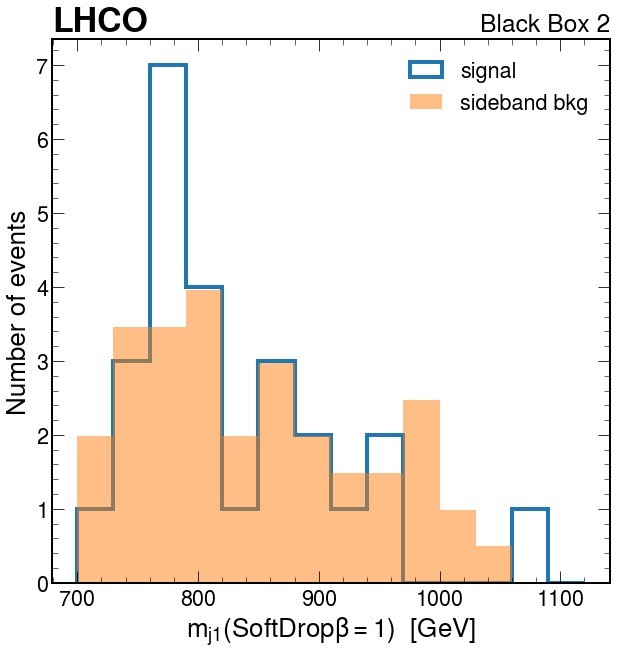

In [224]:
bins = np.arange(700,1150,30)
#sideband_left = plt.hist(j1sdb1[bbidx][(mjj[bbidx]<3600)&(mjj[bbidx]>3400)])
sideband = j1sdb1[bbidx][((mjj[bbidx]<4800)&(mjj[bbidx]>4300)) | ((mjj[bbidx]<5800)&(mjj[bbidx]>5300))]
sigregion = j1sdb1[bbidx][((mjj[bbidx]<5300)&(mjj[bbidx]>4800))]
plt.hist(sigregion,bins=bins,density=False,alpha=1,label='signal',histtype='step',linewidth=4)
plt.hist(sideband,bins=bins,density=False,weights=np.ones(len(sideband))*((len(sigregion))/(len(sideband))),alpha=0.5,label='sideband bkg')

#b = plt.hist(j1sdb1_bkg[bkgidx],bins=np.arange(300,1400,50),density=True,alpha=0.3)
#print(a,b)
#c = np.max((a[0]-b[0],np.zeros(len(a[0]))),axis=0)
#bincenters = 0.5*(a[1][:-1]+a[1][1:])
#plt.plot(bincenters,c)
#print(c)
#print(a[1])
#plt.yscale('log')
plt.xlabel(r'$m_{j1}(SoftDrop \beta=1)$  [GeV]')
plt.ylabel('Number of events')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.legend(loc='upper right')
#plt.axvline(x=732)

#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1sdb1.png')


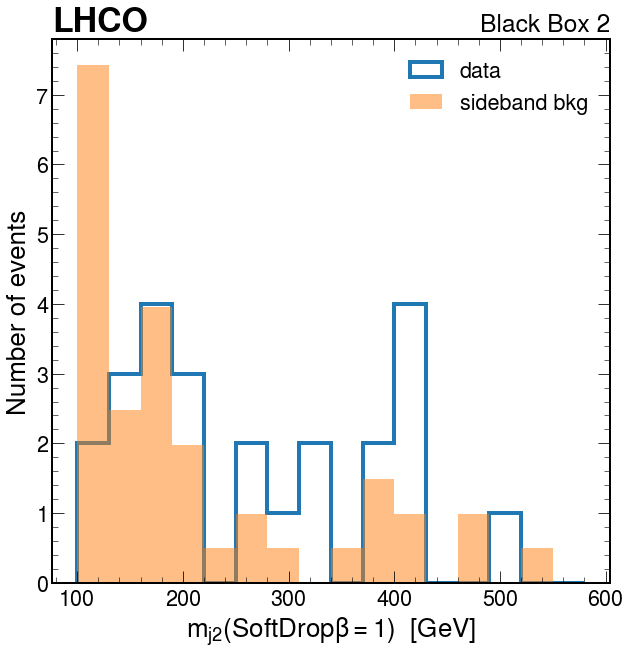

In [229]:
bins = np.arange(100,600,30)
sideband = j2sdb1[bbidx][((mjj[bbidx]<4800)&(mjj[bbidx]>4300)) | ((mjj[bbidx]<5800)&(mjj[bbidx]>5300))]
sigregion = j2sdb1[bbidx][((mjj[bbidx]<5300)&(mjj[bbidx]>4800))]
plt.hist(sigregion,bins=bins,density=False,alpha=1,label='data',histtype='step',linewidth=4)
plt.hist(sideband,bins=bins,density=False,weights=np.ones(len(sideband))*(len(sigregion))/(len(sideband)),alpha=0.5,label='sideband bkg')

#b = plt.hist(j2sdb1_bkg[bkgidx],bins=np.arange(100,1200,40),density=True,alpha=0.3)
#c = np.max((a[0]-b[0],np.zeros(len(a[0]))),axis=0)
#bincenters = 0.5*(a[1][:-1]+a[1][1:])
#plt.plot(bincenters,c)
plt.xlabel(r'$m_{j2}(SoftDrop \beta=1)$  [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.axvline(x=378)
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2trimmed.png')

In [179]:
dt = f_BB1.values

In [180]:
dt_rnd = f_rnd.values

In [181]:
correct = (dt[:,3]>0) &(dt[:,19]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
        
        
correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]

In [182]:

rnd_idx = dt_rnd[:,-1]
print(rnd_idx[:30])

correct = (dt_rnd[:,3]>0) &(dt_rnd[:,19]>0)
dt_rnd = dt_rnd[correct]
for i in range(13,19):
    dt_rnd[:,i] = dt_rnd[:,i]/dt_rnd[:,3]
    
for i in range(29,35):
    dt_rnd[:,i] = dt_rnd[:,i]/(dt_rnd[:,19])
        
        
correct = (dt_rnd[:,29]>=0) &(dt_rnd[:,29]<=1)&(dt_rnd[:,30]>=0) &(dt_rnd[:,30]<=1)&(dt_rnd[:,31]>=0) &(dt_rnd[:,31]<=1)&(dt_rnd[:,32]>=0) &(dt_rnd[:,32]<=1)&(dt_rnd[:,33]>=0) &(dt_rnd[:,33]<=1)&(dt_rnd[:,34]>=-0.01) &(dt_rnd[:,34]<=1)
dt_rnd = dt_rnd[correct]

rnd_idx = dt_rnd[:,-1]
print(rnd_idx[:30])
print(len(rnd_idx))
correct = np.where(rnd_idx == 0)[0]
print(len(correct))
dt_bkg = dt_rnd[correct]

[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]
1013459
938331


In [183]:
bb_mass = dt[:,0]
bb_j1trim = dt[:,3] * dt[:,13]
bb_j2trim = dt[:,19] * dt[:,29]

bb_j1sdb1 = dt[:,3] * dt[:,16]
bb_j2sdb1 = dt[:,19] * dt[:,32]

bb_j1raw = dt[:,3]

In [184]:
bkg_mass = dt_bkg[:,0]
bkg_j1trim = dt_bkg[:,3] * dt_bkg[:,13]
bkg_j2trim = dt_bkg[:,19] * dt_bkg[:,29]

bkg_j1sdb1 = dt_bkg[:,3] * dt_bkg[:,16]
bkg_j2sdb1 = dt_bkg[:,19] * dt_bkg[:,32]

bkg_j1raw = dt_bkg[:,3]

In [185]:
#dt_rnd = f_rnd.values
#rnd_idx = dt_rnd[:,-1]

In [186]:
#improve purity of trainig by only selecting properly reconstructed jets 

# APPLY PRESELECTION BEFORE DOING THE FIT TO THE LDA

In [187]:
def generate_X(whichsample):
    #bkgloss_0 = np.load(f'../data_strings/bkgae_rndbkg_loss_{whichsample}.npy')
    bkgloss_1 = np.load(f'../data_strings/bkgae_purebkg_withmass_turnonselection_Huberloss_beta1_WAICloss_{whichsample}.npy')
    sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_5tausMasRatioNoRawMass_turnonselection_MSELoss_beta1_z6f8_Justloss_{whichsample}.npy')
    #sigaeloss_1 = np.load(f'../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta1_WAICloss_{whichsample}.npy')
    sigaeloss_1 = np.load(f'../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta0p1_WAICloss_{whichsample}.npy')
    bkgloss_1[bkgloss_1 > 1e6 ] = 1e6
    sigaeloss_0[sigaeloss_0 > 1e6 ] = 1e6
    sigaeloss_1[sigaeloss_1 > 1e6 ] = 1e6
    
    #print(np.max(bkgloss_0))
    print(np.max(bkgloss_1))
    print(np.max(sigaeloss_0))
    print(np.max(sigaeloss_1))
    
    print(len(bkgloss_1))
    
    
    return np.column_stack((bkgloss_1,sigaeloss_0,sigaeloss_1))

In [190]:
BB1 = generate_X('bb1')

1000000.0
13511.104
20021.203
914617


In [191]:
BKG = generate_X('rndbkg')

1000000.0
15482.961
22914.14
938331


(0.0, 200.0)

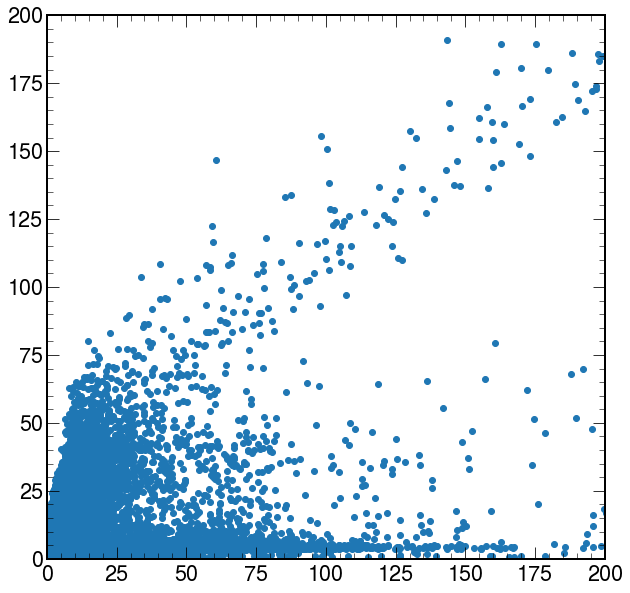

In [192]:
plt.scatter(BB1[:100000,0],BB1[:100000,1])
plt.xlim([0,200])
plt.ylim([0,200])

In [193]:
len(BB1[:,0])

914617

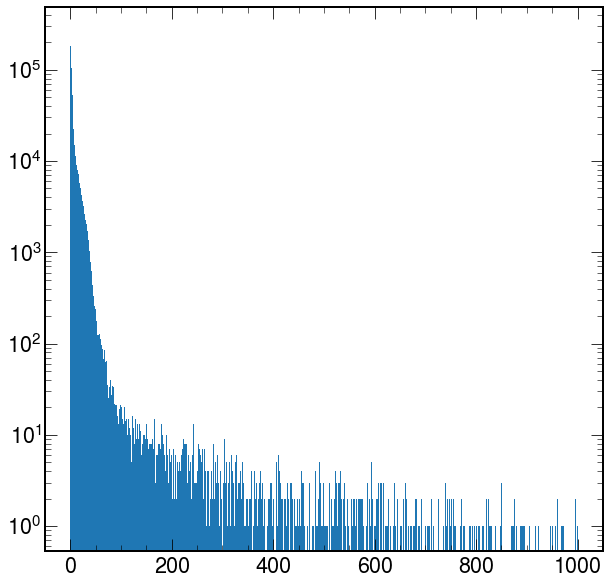

In [194]:
plt.hist(BB1[:,1],bins=np.linspace(0,1000,1000));
#plt.xscale('log')
plt.yscale('log')

# BLACK BOX 1

In [195]:
#bb1_index = np.where((BB1[:,0]>23) & (BB1[:,1]<1.5) & ((dt[:,13]>0.9)) & ((dt[:,0]>4000)) )[0]
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0)   & ((dt[:,0]<5000)) & ((dt[:,0]>3500)))[0]


#####BB1 default cut #####
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0)  )[0]


##### BB1 with 3 prong prior
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,2]<.8)  )[0]

### BB1 with both prior

#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0) & (BB1[:,2]<.8)  )[0]

# BLACK BOX 2

In [232]:
###### BB Testing
bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<.5)   )[0]
bkg_index = np.where((BKG[:,0]>15) & (BKG[:,1]<.5)   )[0]

In [233]:
#####BB2 2prong prior #####
#bb1_index = np.where((BB1[:,0]>8.6) & (BB1[:,1]<0.5)  )[0]
       # 2prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.1) & (bb_j2trim> 200) &(bb_j1trim>600))[0]

#####BB2 3 prong prior
#bb1_index = np.where((BB1[:,0]>10.3) & (BB1[:,2]<.5)  )[0]
     #3prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>8) & (BB1[:,2]<1.5)  & (bb_j2trim> 200) &(bb_j1trim>600) )[0]

###### BB2 with both prior
# bb1_index = np.where((BB1[:,0]>16) & (BB1[:,1]<1.3) & (BB1[:,2]<0.8)   )[0]
# bkg_index = np.where((BKG[:,0]>16) & (BKG[:,1]<1.3) & (BKG[:,2]<0.8)   )[0]
#both prior, masstrim
#bb1_index = np.where((BB1[:,0]>12) & (BB1[:,1]<1) & (BB1[:,2]<1) & (bb_j2trim> 200)  )[0]

# Black Box 3

In [234]:
#####BB3 2prong prior #####
#bb1_index = np.where((BB1[:,0]>6) & (BB1[:,1]<.8)  )[0]
       # 2prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>6) & (BB1[:,1]<1.1) & (bb_j1trim> 500) &(bb_j2trim>200))[0]

#####BB3 3 prong prior

#bb1_index = np.where((BB1[:,0]>8) & (BB1[:,2]<.6)  )[0]
     #3prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>1) & (BB1[:,2]<.6)  & (bb_j1trim> 600) &(bb_j2trim>200) )[0]

###### BB3 with both prior
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.3) & (BB1[:,2]<1.3))[0]
        #allprior with tau cut on jet 1
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.3) & (BB1[:,2]<1.3) & (dt[:,5]>0.4) )[0]

In [235]:
#bb1_index = np.where((BB1[:,0]>4.) & ((dt[:,13]>0.6)))[0]

In [236]:
print(len(bb1_index),len(bkg_index))

453 163


In [237]:
BBTYPE = 'Black Box 1'
#priorusage = '2prongprior'
#priorusage = '2prongprior_withtrimmedmasscutbyeyeball'
#priorusage = '3prongprior'
#priorusage = '3prongprior_withtrimmedmasscutbyeyeball_j1200j2600'
#priorusage = 'allprior'
priorusage = 'TEST'
BBTYPE_FILENAME = 'BB1'
savedir = 'plots'

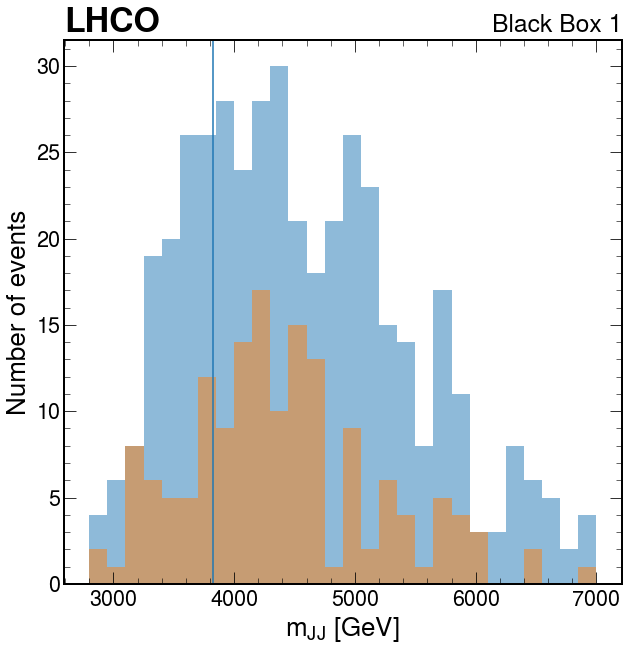

In [239]:
plt.hist(bb_mass[bb1_index],bins=np.linspace(2800,7000,29),alpha=0.5)
plt.hist(bkg_mass[bkg_index],bins=np.linspace(2800,7000,29),alpha=0.5)

plt.axvline(x=3823)
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
#plt.title('subplot 1')
#hep.cms.cmslabel(data=False, paper=False, year='2017')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.legend(loc='upper right')
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_MJJ.png')
#print(a)

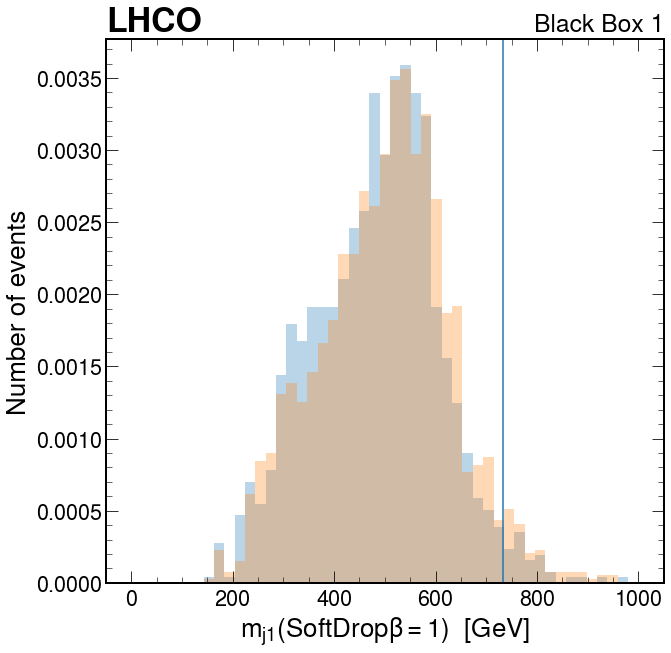

In [177]:
plt.hist(bb_j1sdb1[bb1_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)
plt.hist(bkg_j1sdb1[bkg_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)

plt.xlabel(r'$m_{j1}(SoftDrop \beta=1)$  [GeV]')
plt.ylabel('Number of events')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.axvline(x=732)
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1trimmed.png')


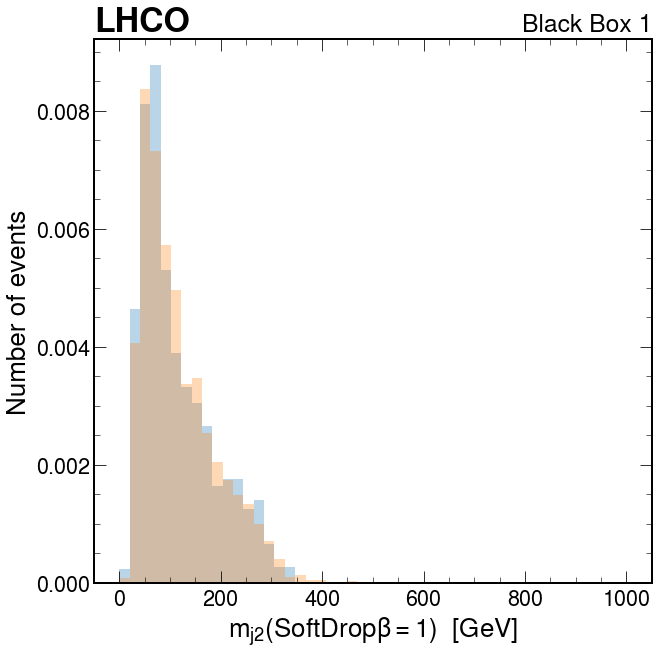

In [178]:
plt.hist(bb_j2sdb1[bb1_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)
plt.hist(bkg_j2sdb1[bkg_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)

plt.xlabel(r'$m_{j2}(SoftDrop \beta=1)$  [GeV]')
plt.ylabel('Number of events')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.axvline(x=378)
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2trimmed.png')


In [ ]:
plt.hist(dt[bb1_index,4],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,4],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper right')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet1\ \tau_{21}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1tau21.png')



In [ ]:
plt.hist(dt[bb1_index,5],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,5],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')

hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet1\ \tau_{32}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1tau32.png')


In [ ]:
plt.hist(dt[bb1_index,20],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,20],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet2\ \tau_{21}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2tau21.png')

In [ ]:
plt.hist(dt[bb1_index,21],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,21],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet2\ \tau_{32}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2tau32.png')

In [ ]:
from scipy.stats import percentileofscore

In [ ]:
percentiles = [percentileofscore(BB1[:,2], i) for i in BB1[:,2]]

In [ ]:
plt.scatter(BB1[:,0],BB1_prob[:,1])
plt.xscale('log')

In [ ]:
def get_loss(X):
    